# TP4 - Background Substraction
ATRIM - Option Datasim

Ecole Centrale Nantes

Diana Mateus

Participants: (FILL IN YOUR NAMES AND LASTNAMES)

### BACKGROUND SUBSTRACTION 

The goal of this TP is to enhance the video of a neurointervention  to improve the visualization of moving tools. To this end you will implement a pipeline of image processing methods to detect the moving tools automatically. 


#### Methodology

As the brain is mostly static one way to detect the moving tools is to substract the background (first image) from each of the subsequent images. However, the results of this step need to be further improved. To this end, you will design a pipilene with the methods learnt in this course to produce a binary mask for the pixels that belong to the tools. 

In your pipeline use at least:
- one histogram transformation
- one morphological operation
- one filtering operation in the spatial domain
- one filtering operation in the spectral domain
- one segmentation method

_The same pipeline should be applied to every image_


#### Expected output

The output of your image processing pipeline should be one binary image mask (with values 0 or 1) for every input image of the sequence, where 
- the zero valued pixels indicate the moving tools inside each image.  
- the pixels with value 1 indicate the background (not a moving tool)

To validate the proposed method, a human has annotated (manually drawn) the tools of interest within the images. The annotated pixels belong either to catheters or guidewires. **Your masks should be as close as possible to the human annotations.**


#### Visualization of data and manual annotations

- Data visualization  (**do not include in final version**): visualize the neurointervention images in the ``` catheter``` folder with name ```frame_#```

- Individual Annotation visualization  (** do not include in final version**): visualize the manual annotations in the ```catheter``` folder with names ``` #_MicroCath``` and ```#_GuideWire```. 

- Individual Annotation visualization  (** do not include in final version**): visualize the full manual annotation (union of the guidewire and microcatheter masks) by composing the union of the ``` #_MicroCath``` and ```#_GuideWire```. It should also be a binary mask.



#### Experimental (quantitative and qualitative  validation)

To compare your results and the manual annotations use the mean SAD (Sum of Absolute Differences) and the SNR (Signal to Noise Ratio) errors between your  mask and  the **full** manual mask. 

Present the results qualitatively and quantitatively:

- Qualitatively: 
     - Show your mask side by side with the manually annotated mask
     - Create an enhanced image suitable for guidance: enhance the contrast of the image and overlay your mask on the green channel of the enhanced image.

- Quantitatively: 
    - compute and print the SAD (sum of absolute differences) error per image. 
    - compute and print the MSE (sum of squared  differences ) error per image.
    - compute and print the PSNR (Peak signal to noise ratio) taking as reference image the manual annotations. 
    - Then compute and print the mean and standard deviation of the three measures (SAD, MSE and PSNR) over the entire sequence.
    
Hints:
```
mse = numpy.mean( (img1 - img2) ** 2 )
PIXEL_MAX = 255.0 #or 1.0 or max over the signal of interest
psnr = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
```
or look at ```skimage.measure``` module

You may use modules such as ```scipy```, ```skimage``` or ``sklearn``(e.g. for clustering with K-means or a Gaussian Mixture Model). Ask me for other external modules.


### REPORT INSTRUCTIONS

#### 1. Intermediate Steps (Code and Description)
Report the results of the intermediate steps (when you add or remove a method from the pipeline):
- provide a text introduction with the idea that you intend to try
- show the implementation of the idea with code 
- evaluate the quantitative and qualitative changes  when including, varying, adapting, etc the proposed method
- Discuss the scores or visualization improvements/degradations 

#### 2. Final Pipeline (Code and Description)
Provide a detailed description of the best performing pipeline. Comment the code such that it is straightforward to relate the pipeline description to the code. Add your conclusions

- Describe the final retained pipeline
- Give a justification for every step (e.g. supported by experimental intermediate steps or theory). 
- Add the **commented** code
- Display the qualitative and quantitative results 
- Give your conclusions

In [ ]:
REPORT: 

In [91]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.color import rgb2gray
import skimage.morphology as sc
from scipy import ndimage
from math import sqrt
from skimage.restoration import denoise_bilateral

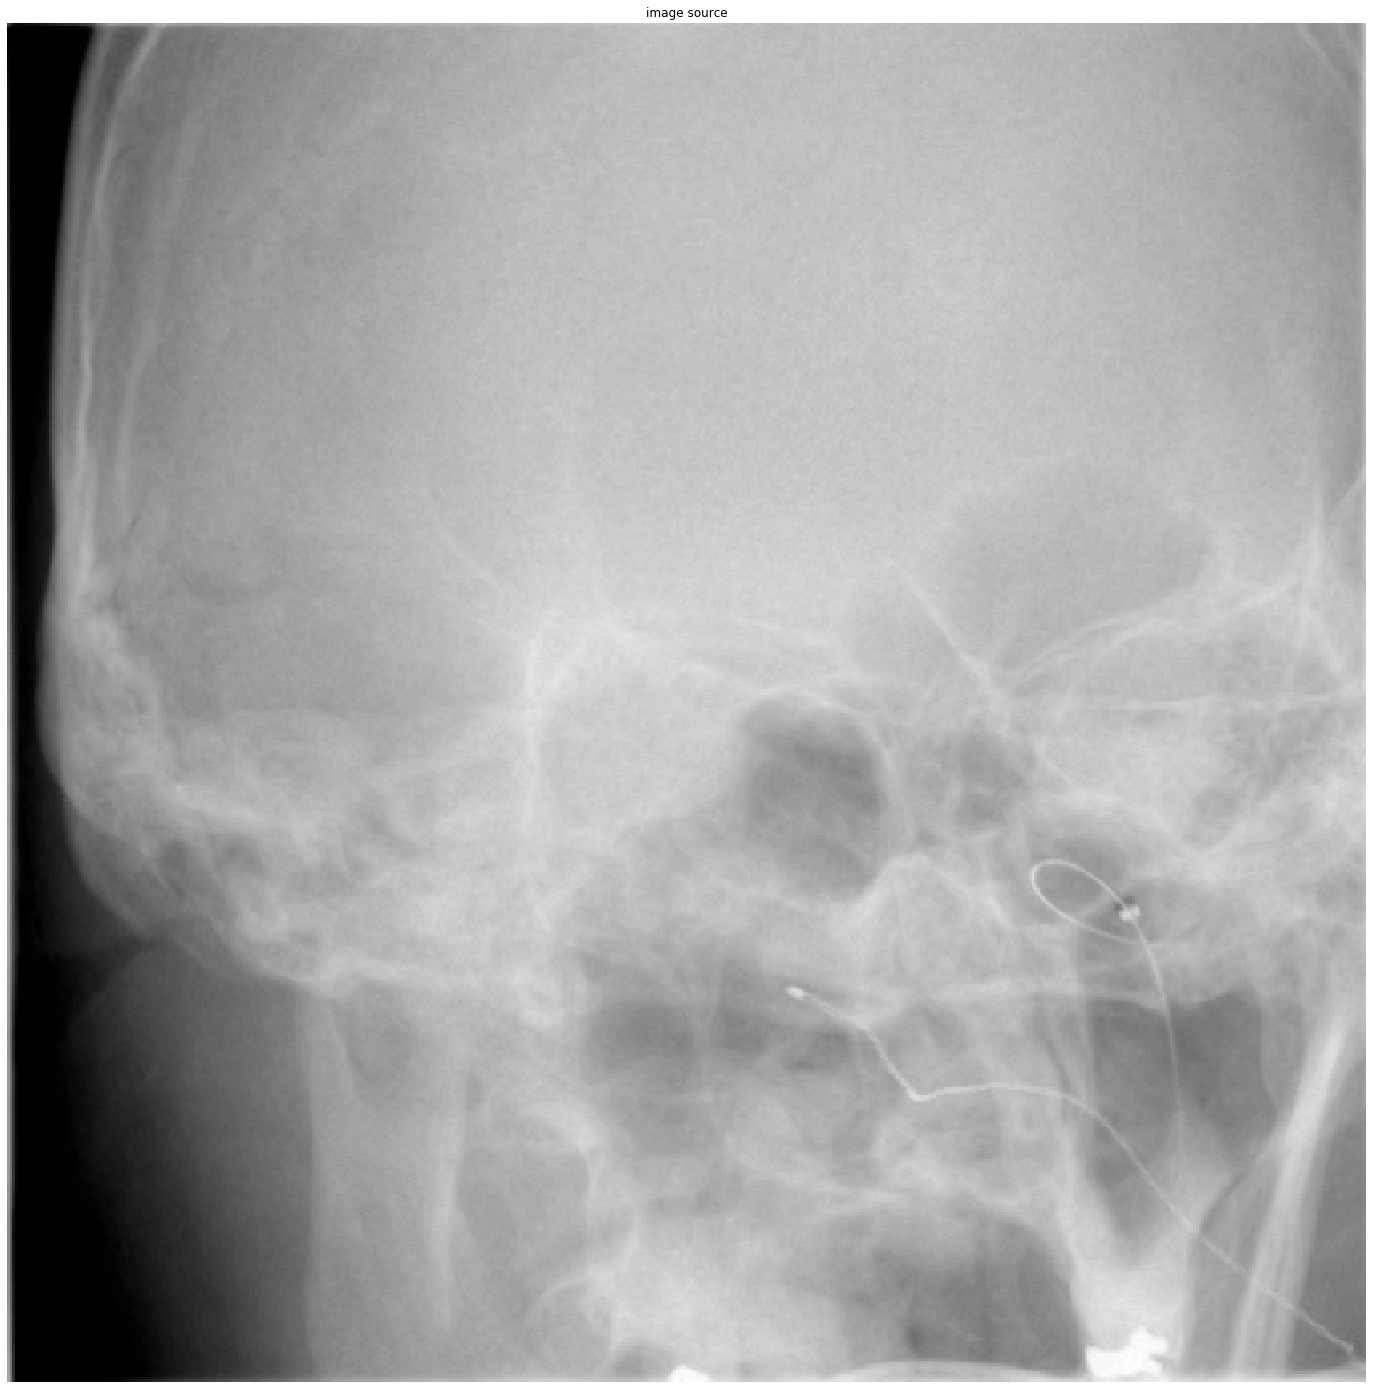

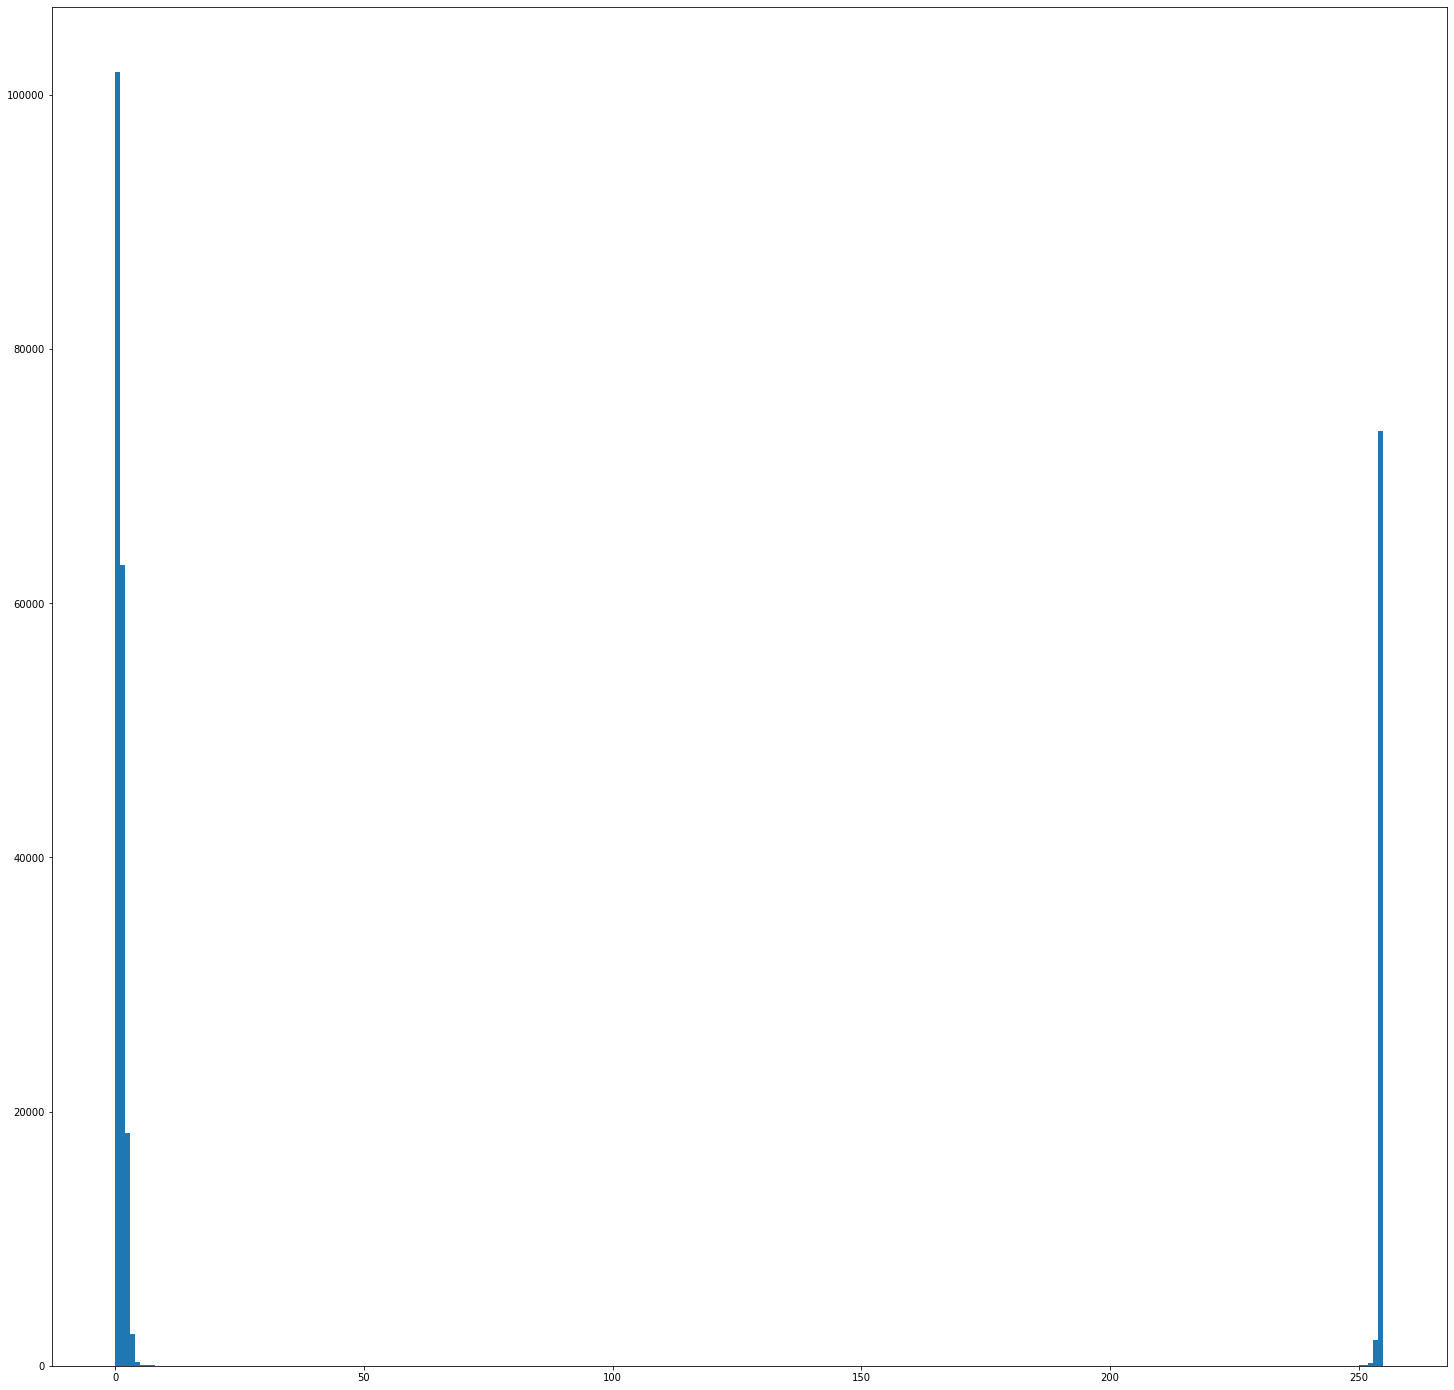

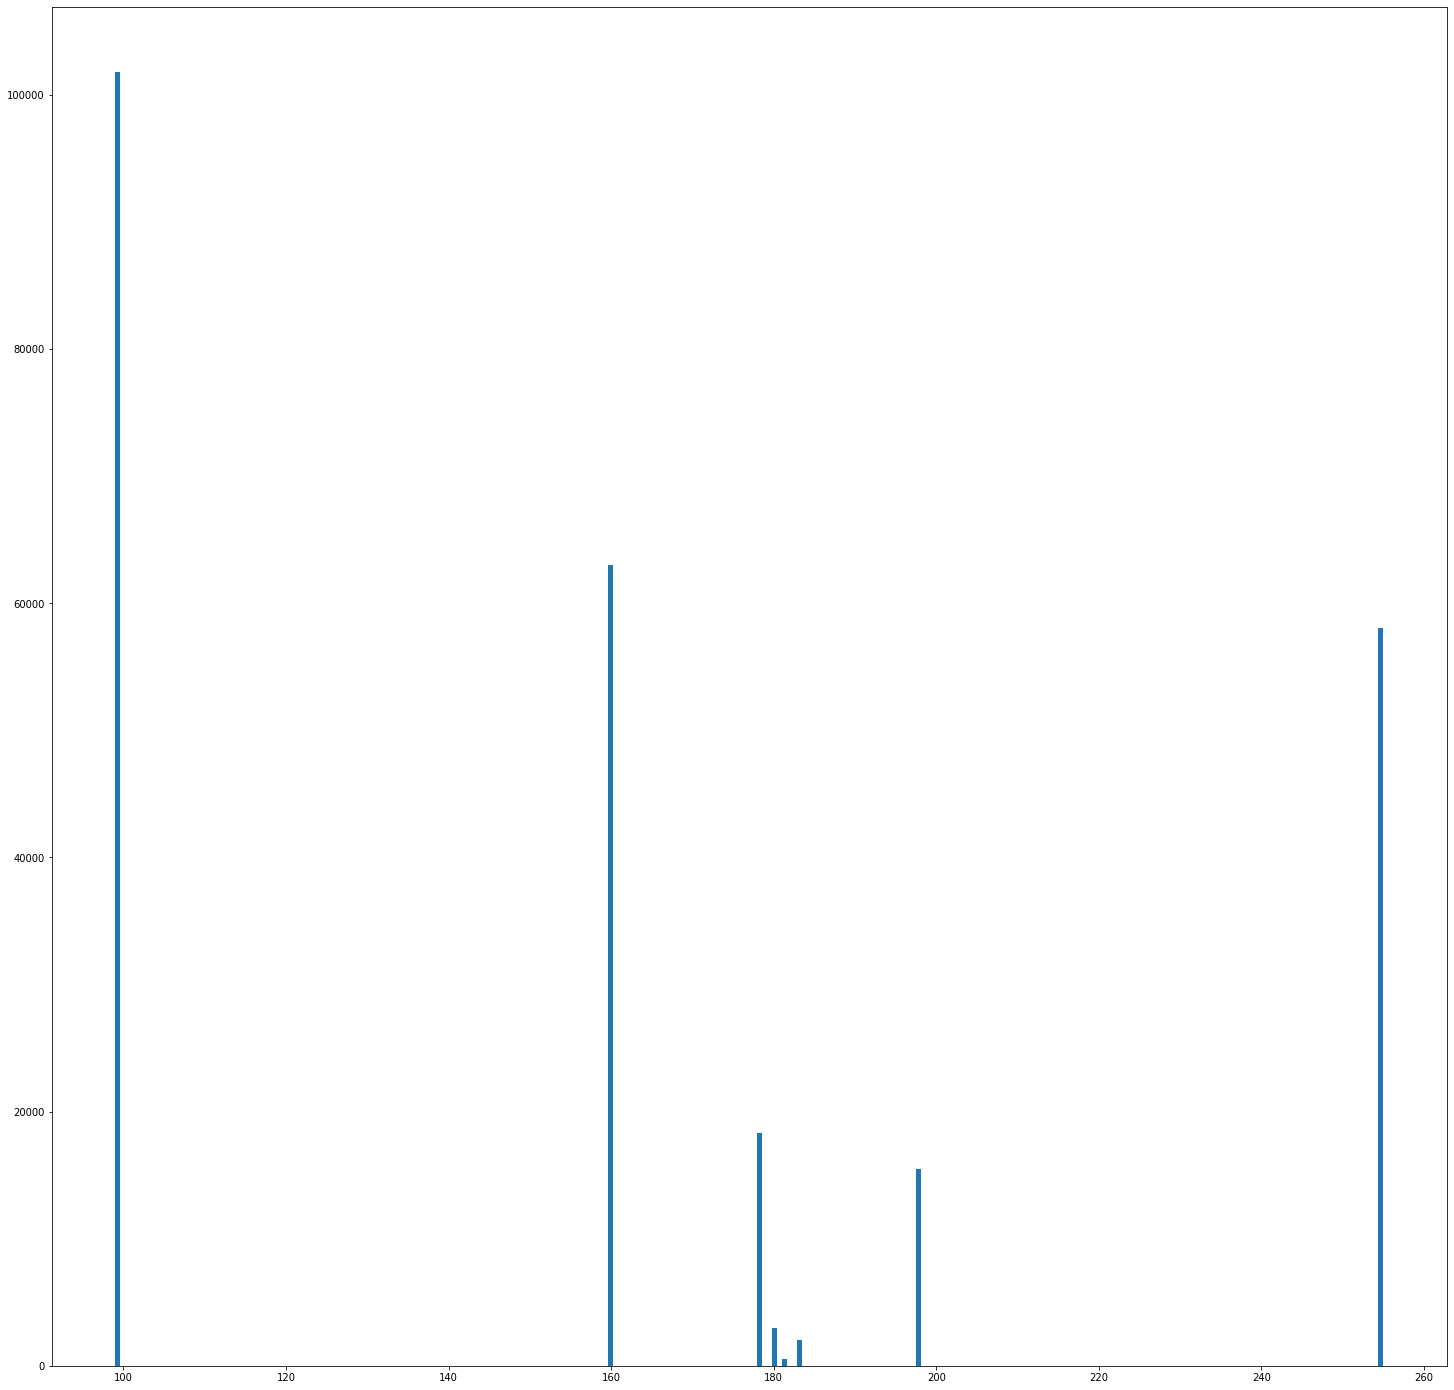

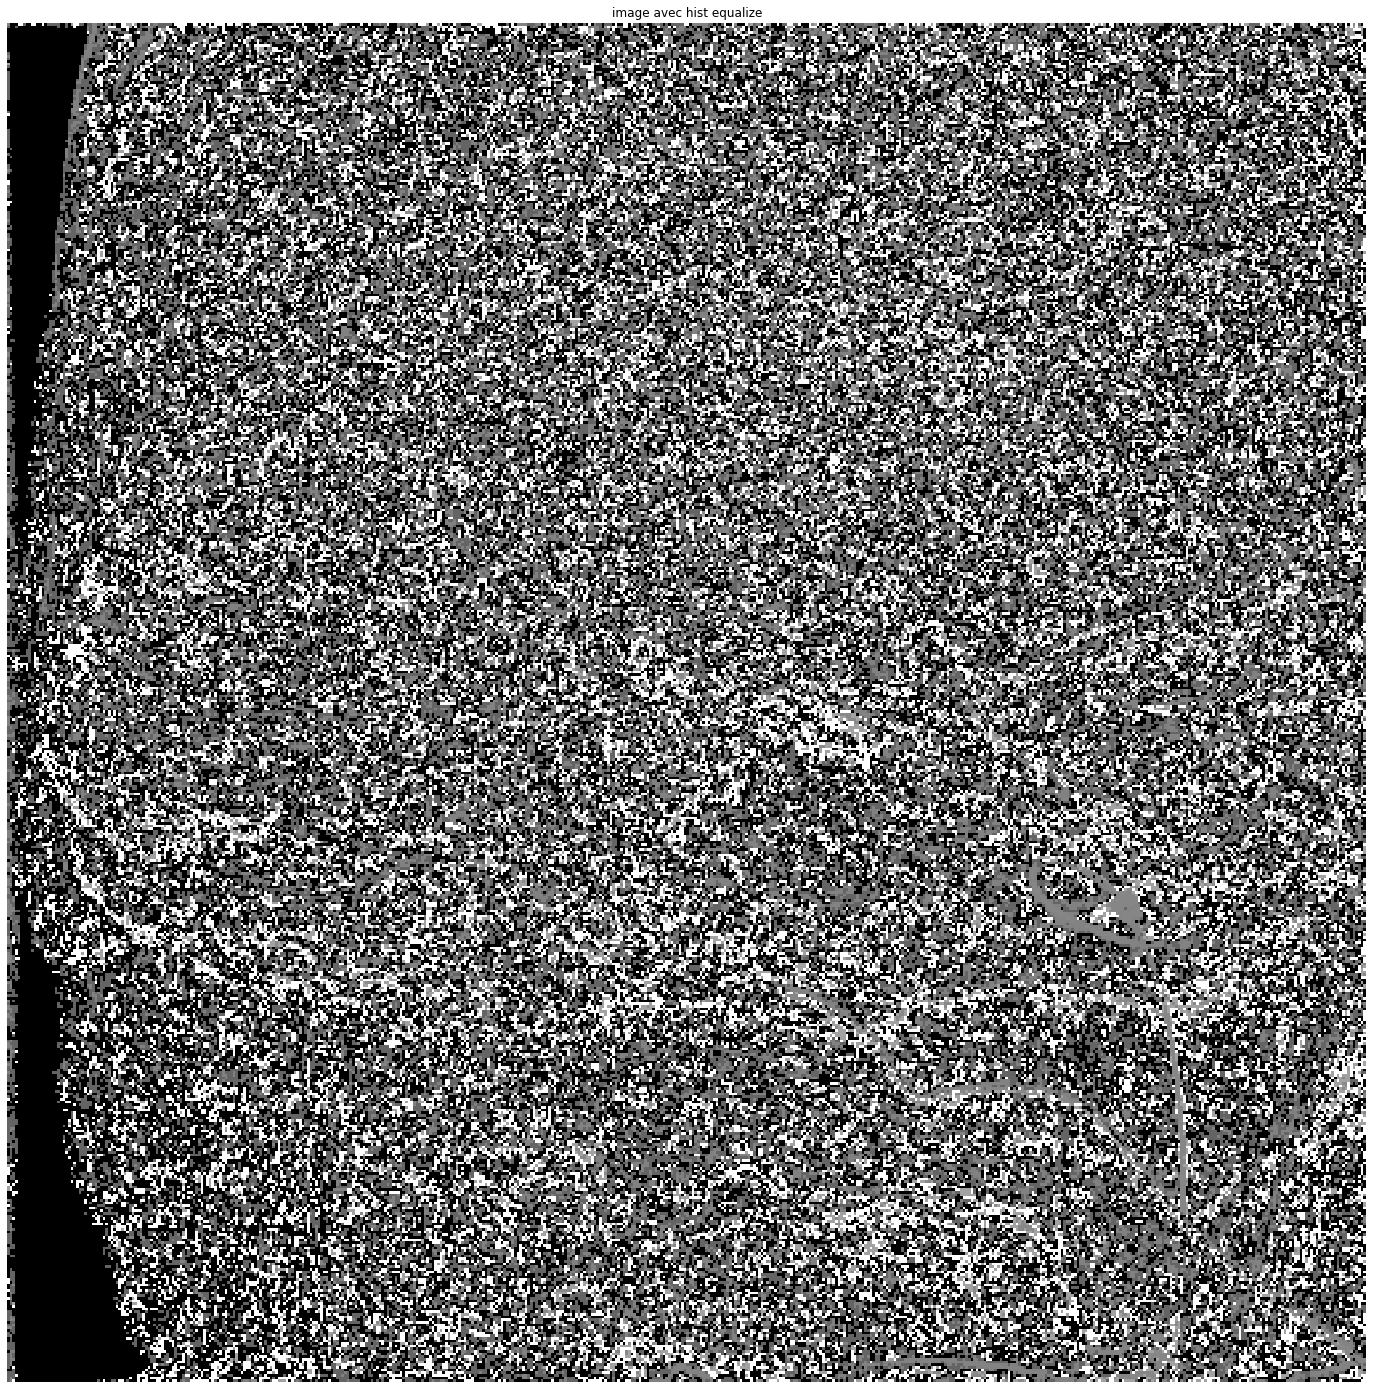

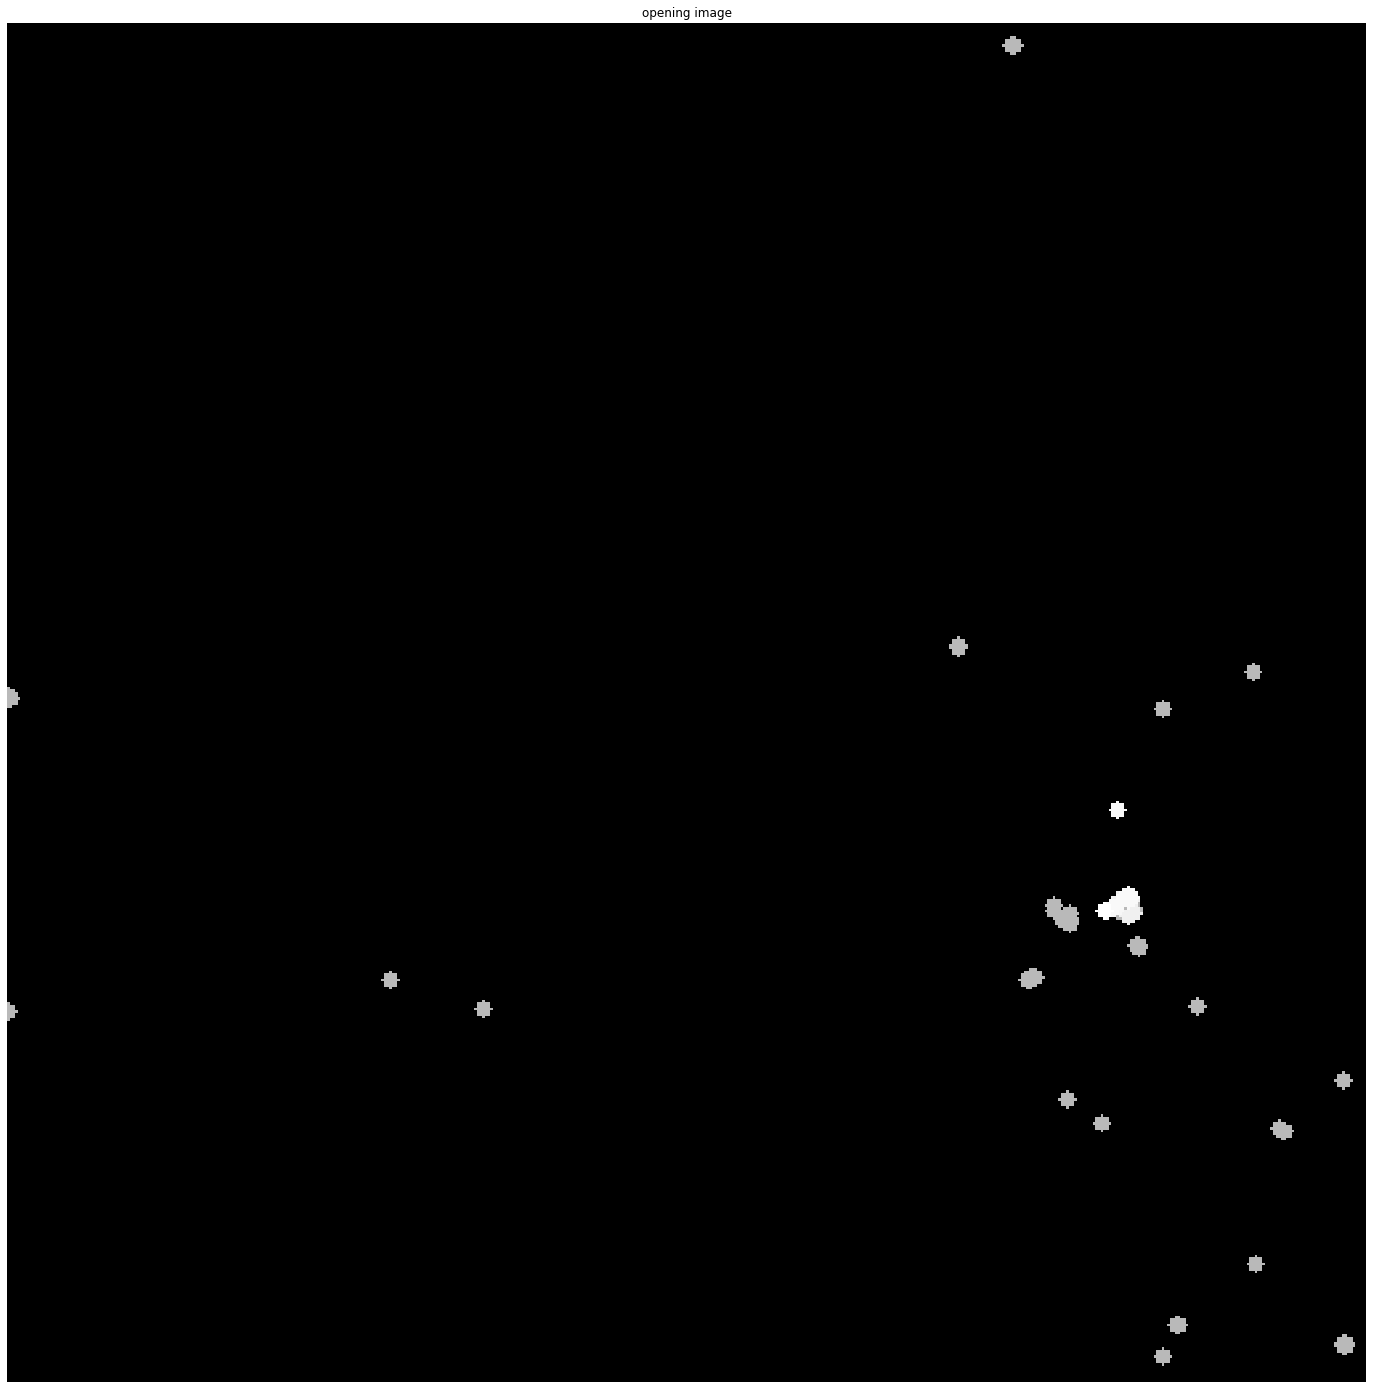

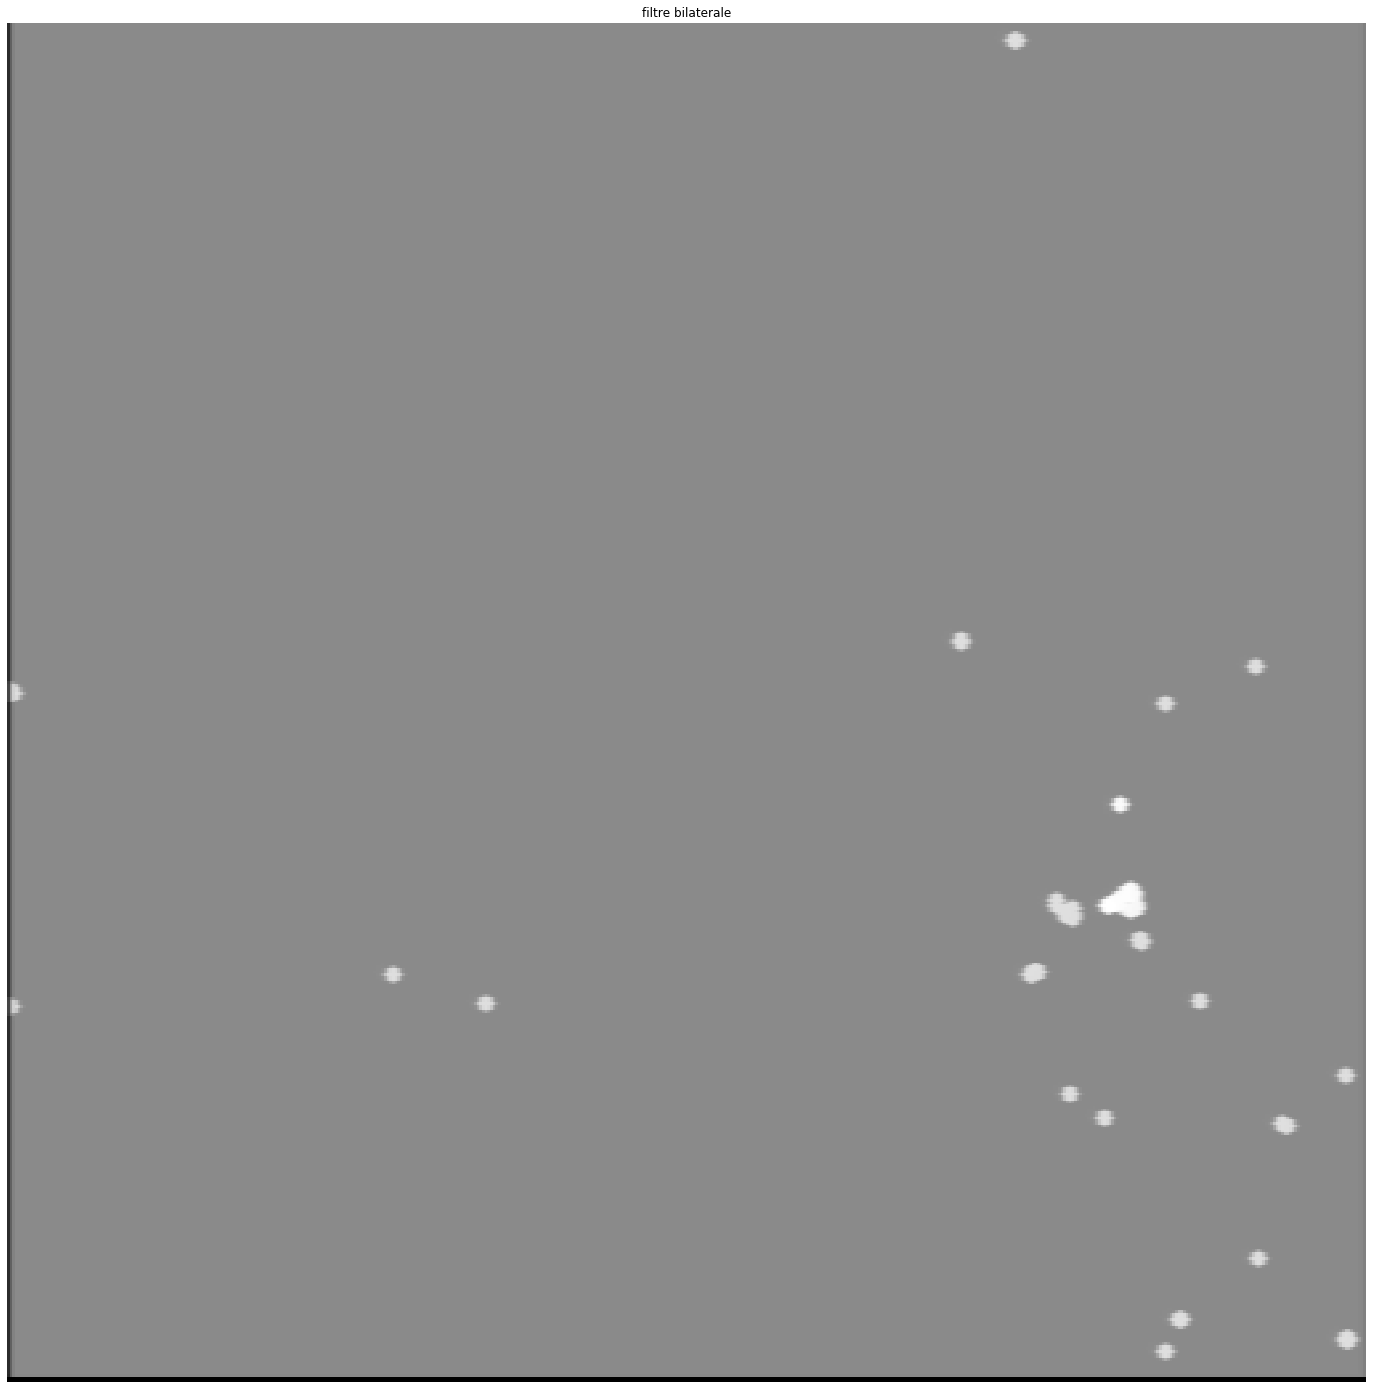

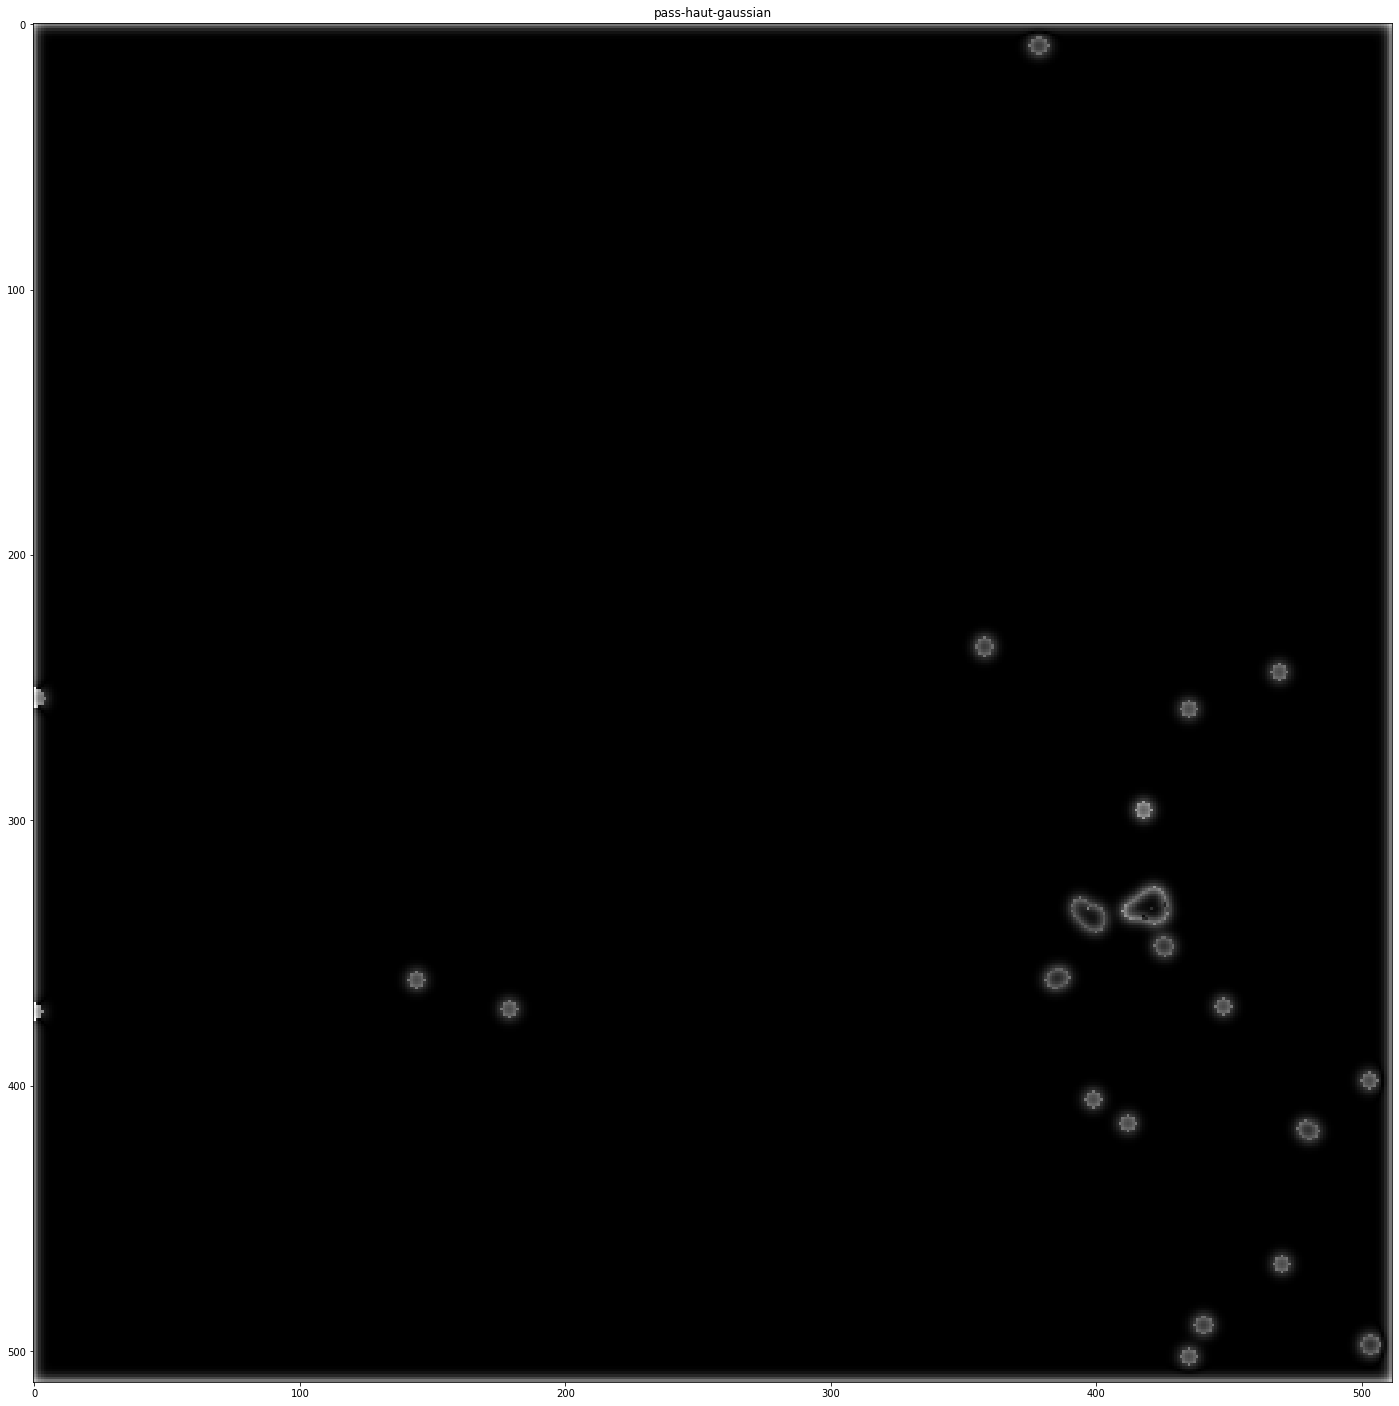

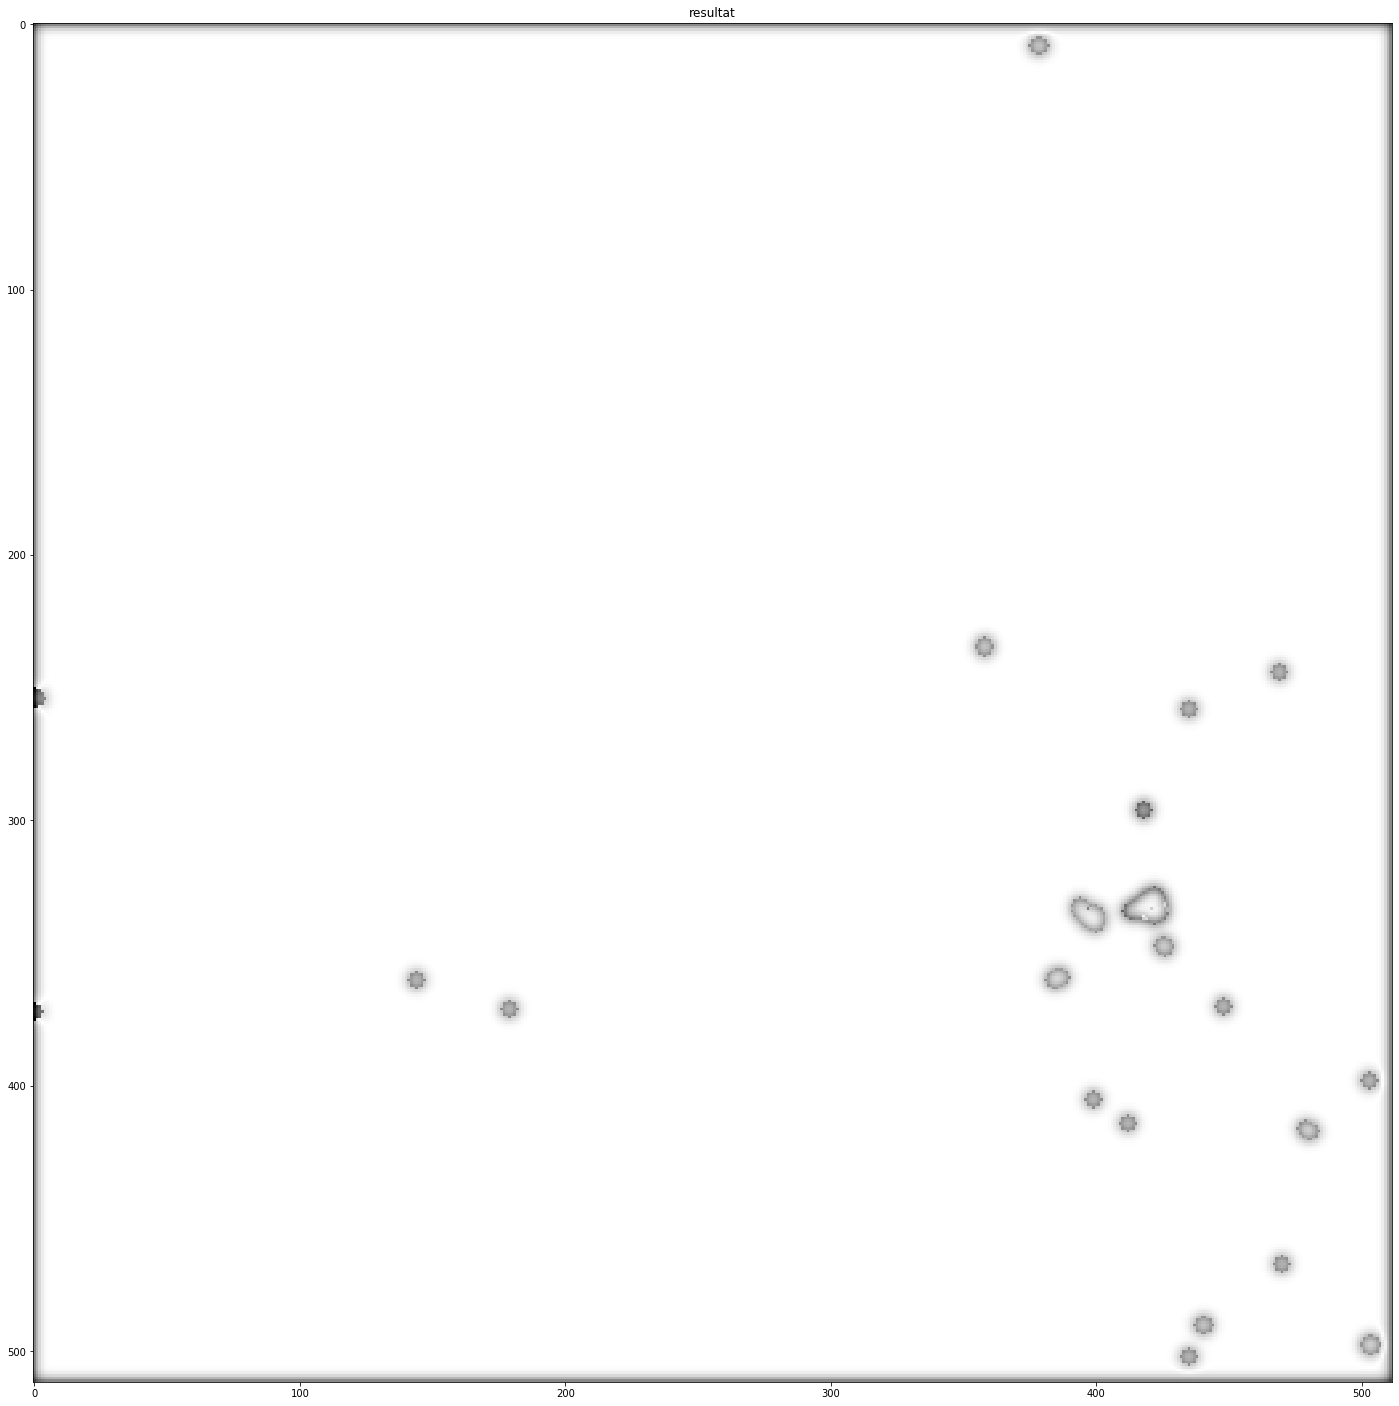

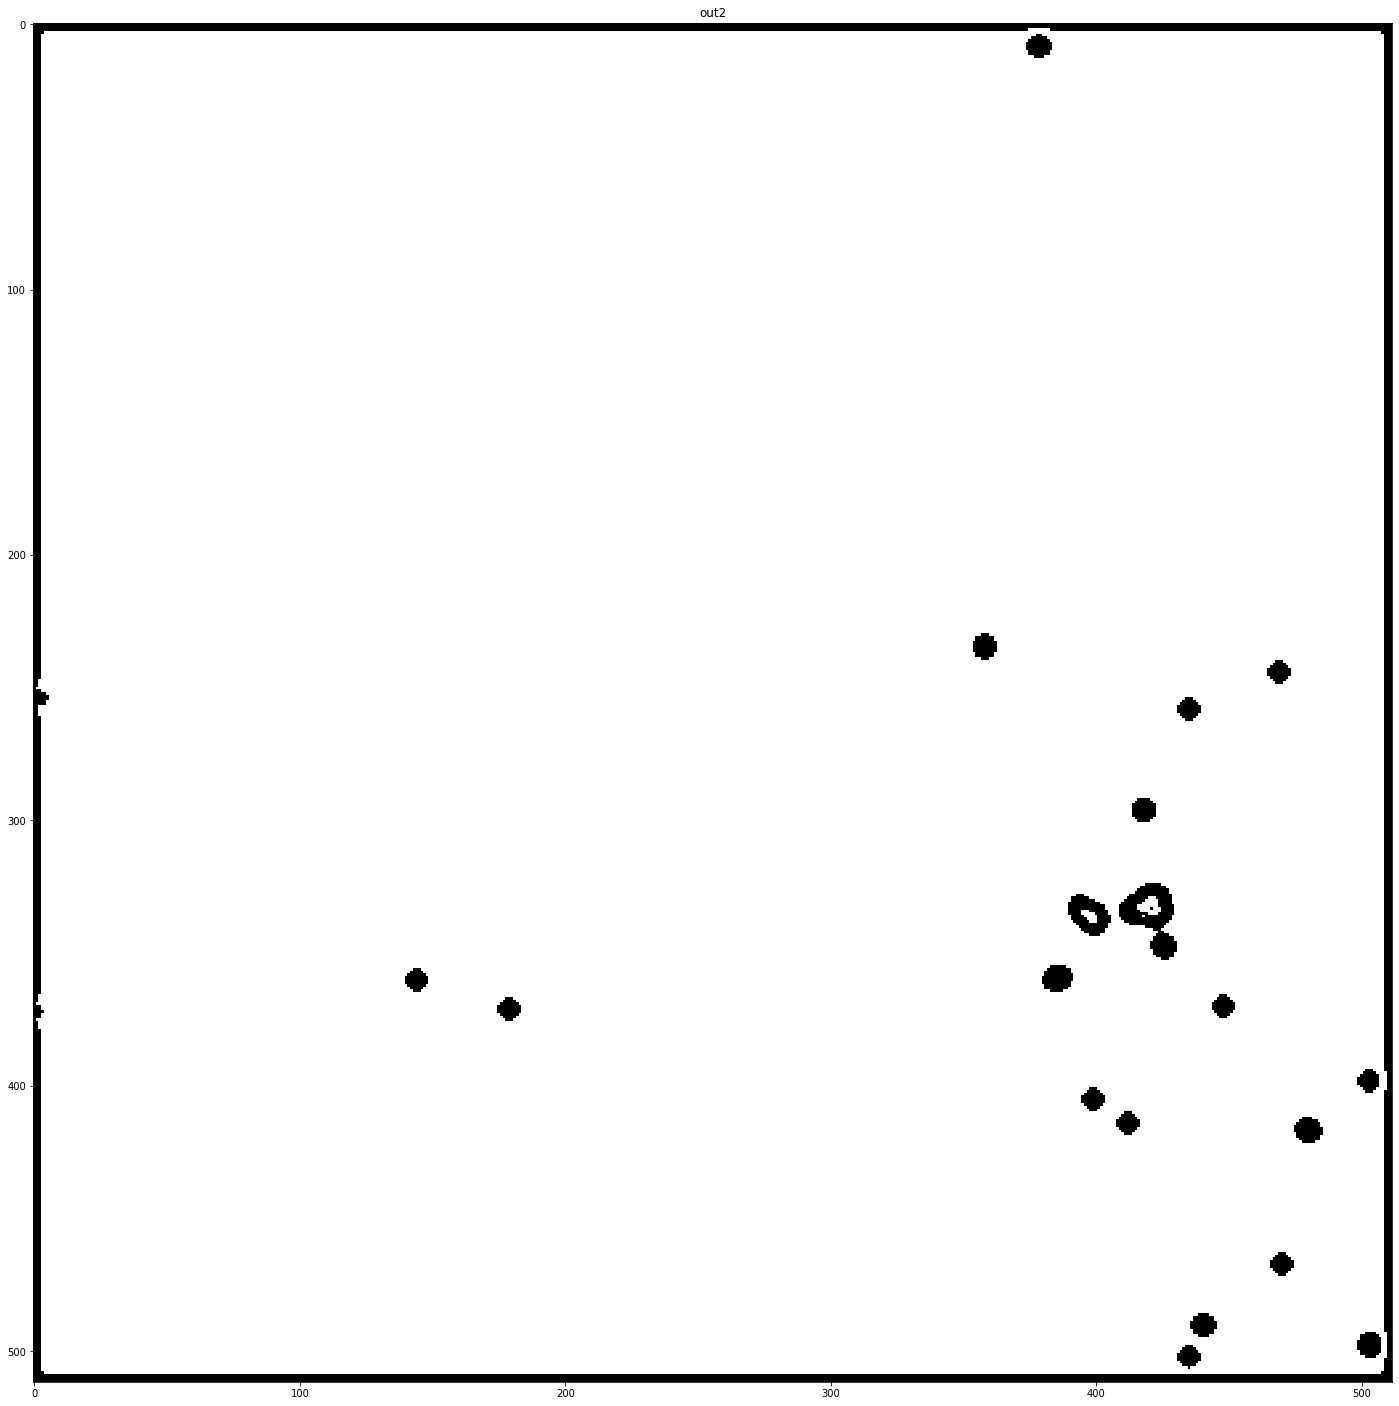

In [113]:
width = 25
height= 25
plt.rcParams['figure.figsize'] = [width, height]

#Visualisation de l'imge 

im1 = io.imread('./catheter/frame_201.jpeg')
im2 = io.imread('./catheter/frame_221.jpeg')
im1 = im1-im2
plt.imshow(im1-im2,cmap = 'gray')
plt.title('image source')
plt.axis('off')
plt.show()

# Amélioartion de l'histogramme

#Pour distinguer plus les couleurs au voisinage de l'outil, on a pensé à l'equalilzation de l'histogramme qui permet
#une meilleur amélioration des contrastes.

plt.hist(im1.flatten(),255)
plt.show()

def histo_equa(image):
    im=rgb2gray(image)
    y=np.histogram(im.flatten(),256)
    t=y[0]
    M=len(image)
    N=len(image[0])
    taille=M*N
    t=t/taille
    for i in range(1,len(t)):
        t[i]+=t[i-1]
    for i in range(M):
        for j in range(N):
            im[i,j]=255*t[int(im[i,j])]
    return im

im_eq1 = histo_equa(im1)
plt.hist(im_eq1.flatten(),255)
plt.show()
plt.imshow(im_eq1,cmap = 'gray')
plt.title('image avec hist equalize')
plt.axis('off')
plt.show()

# On miniser les donées inutiles on mettant un seuil sur l'histogramme pour n'extraire que les pixels 
# avec un niveau de gris proche de l'outil. Mais le problème qu'on rencontré est dans la détermination du seuil optimal

#for i in range(len(im_eq)):
    #for j in range(len(im_eq[0])):
        #if im_eq[i,j] > 200 :
            #im_eq[i,j] = 255
#plt.imshow(im_eq,cmap = 'gray')
#plt.title('image avec hist equalize')
#plt.axis('off')
#plt.show() 


# Opération de morphologie

#Dans cette partie,on a remarqué que le voisinage de l'outil est peu bruillant,
#C'est pourquoi on a choisi l'opérataion de morphologie 'opening' qui permet de flouer les parties secondaies(trop bruité) 
#de l'image, ce qui va aider à une extraction plus simple de l'outil. 

selem = sc.disk(3)
# avec un disque de taille grande les bordures sont grandes ce qui rend la détection de l'outil 
opening_im1 = sc.opening(im_eq1, selem)
plt.imshow(opening_im1,cmap = 'gray')
plt.title("opening image")
plt.axis('off')
plt.show()

# Filtrage spatile

# Pour lisser les parties floués par l'opération précedente, on a envisagé à utiliser le filtre gradient magnitude, mais 
# le problème est que cette méthode est limité dans ce cas parce que les intensités sont proches.

"""def magnitude(kernel_x,kernel_y):
    mag = np.sqrt(kernel_x**2 + kernel_y**2)
    return mag

kernel_x = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
kernel_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
im_lap = ndimage.convolve(opening_im,magnitude(kernel_x,kernel_y))
plt.imshow(im_lap,cmap='gray')
plt.title('gradient magnitude')
plt.axis('off')
plt.show()"""


# Pour lisser et réduire le bruit en presevant les bords, on a essayé le filtre bilaterale pour ne pas perdre l'information 
# sur l'outil

im_bil1 = denoise_bilateral(opening_im1,sigma_color=0.5)
plt.imshow(im_bil1,cmap='gray')
plt.title('filtre bilaterale')
plt.axis('off')
plt.show()


# Filtrage spectrale

# l'objectif dans cette partie est d'extraire les bordures. Or, puisque les bordures sont situés dans 
# le domaine des grandes fréquences, on a envisagé à utiliser un filtre pass-haut qui permet de les extraire.


def low_filter(D0,P,Q):
    #P*Q est la taille de l'image
    H = np.zeros((P,Q))
    #definition du disque
    D = np.zeros((P,Q))
    for u in range(P):
        for v in range(Q):
            D[u,v]=sqrt((u-(P//2))**2+(v-(Q//2))**2)
            H[u,v] = np.exp(-(D[u,v]**2)/(2*(D0**2)))
    return H

P = 2*len(opening_im1)
Q = 2*len(opening_im1[0])
im1 = np.zeros((P,Q))
im1[:len(opening_im1),:len(opening_im1[0])] = opening_im1
H_high_gaussian = 1 - low_filter(70,P,Q)
TF_im1 = np.fft.fftshift(np.fft.fft2(im1))
TF_res1 = H_high_gaussian*TF_im1
im_filtre1= np.fft.ifftshift(TF_res1)
im_filtre1 = np.fft.ifft2(im_filtre1)
im_filtre1 = np.abs(im_filtre1)[:len(opening_im1),:len(opening_im1[0])]

plt.imshow(im_filtre1,cmap='gray')
plt.title('pass-haut-gaussian')
plt.show()

resultat = -abs(im_filtre1) + 255
plt.imshow(resultat,cmap='gray')
plt.title('resultat')
plt.show()

# Segmentation

def threshold(im,th):
    for i in range(len(im)):
        for j in range(len(im[i])):
            if im[i,j]>th:
                im[i,j]=0
            else:
                im[i,j]=255
    return im

out2=threshold(im_filtre1,12)
plt.imshow(out2,cmap='gray')
plt.title('out2')
plt.show()



In [84]:
print(im_filtre)

[[153.1658387  132.08619254 116.48199076 ... 108.21834562 113.80036911
  113.48464023]
 [133.98800836 105.16624888  82.65774224 ...  76.17806017  87.35836697
   96.09058522]
 [119.27223258  83.53291828  57.46119185 ...  55.47878511  67.98335044
   83.11673994]
 ...
 [ 93.90553516  75.10933042  57.65130535 ...  46.07149335  67.05223257
   95.74702647]
 [110.4599713   96.57343679  81.86606598 ...  65.14967782  85.64203305
  109.72922179]
 [132.10803885 125.96436265 116.42374609 ...  67.36652285  83.61058957
  101.960882  ]]
